In [1]:
import astropy.io.fits as pf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import multiprocessing
import subprocess
import glob
import re
import h5py
%matplotlib inline

### Directorios del proyecto

In [2]:
DIR_PROYECTO       = '/home/matias/tesis/'

DIR_MOSAICOS       = DIR_PROYECTO + 'eagle/*/regiones/'
DIR_CATÁLOGOS      = DIR_PROYECTO + 'eagle/*/catálogos/'
DIR_SEGMENTACIONES = DIR_PROYECTO + 'eagle/*/segmentaciones/'
DIR_MORFOLOGÍAS    = DIR_PROYECTO + 'morfologías/'
DIR_DATOS_EAGLE    = DIR_PROYECTO + 'tablas/'
DIR_LOTZ           = DIR_PROYECTO + 'gm20/'

### Definición de valores de filtro

In [3]:
valores_filtros = {
    'u': 121671348.887,
    'g': 168273491.446,
    'r': 178848396.083,
    'i': 69397708.7252,
    'z': 59157262.0017,
    'upri': 126207773.267,
    'gpri': 149732062.76,
    'rpri': 188318397.068,
    'ipri': 67579475.1401,
    'zpri': 50496673.9991,
}

### Generación del mapa de pesos

In [4]:
hdu = pf.PrimaryHDU(np.ones((256, 256)))
hdu.writeto(DIR_PROYECTO + 'wht1.fits', overwrite=True)

### Generación de archivos para correr el programa de Lotz en modo 'batch'
`zeropt.dat` tiene las magnitudes de base de los mosaicos y `run_gmorph.pro` los mosaicos a procesar. Se generan en el mismo bucle para que el orden de las magnitudes se corresponda con el de los mosaicos.

Borramos los lotes existentes...

In [88]:
for file in glob.glob('*.pro'):
    os.remove(file)

Debido a un error del programa de Lotz que hace que el IDL arroje la excepción "program code area full" en vez de generar un único lote con todos los mosaicos a procesar, generamos varios lotes de hasta 100 mosaicos cada uno. 

In [33]:
# yield successive n-sized chunks from l
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [92]:
N = 1 # chunk size

for filtro_orientación in os.listdir('../eagle'):
    nombre_filtro = filtro_orientación.split('_')[0]
    
    for index, chunk in enumerate(chunks(os.listdir('../eagle/' + filtro_orientación + '/regiones'), N)):
    
        with open('run_gmorph_' + filtro_orientación + '_%02d.pro' % index, 'w') as run_gmorph:
    
            for región in chunk:
                
                fits = pf.open('../eagle/' + filtro_orientación + '/regiones/' + región)
                
                flujo_total_filtro    = np.sum(fits[0].data) / valores_filtros[nombre_filtro] # flujo total / valor de filtro
                magnitud_total_filtro = -2.5 * np.log10(flujo_total_filtro / (3.631e6 * 4.8532896**2))

                nombre = os.path.splitext(región)[0] # separa el nombre del archivo de su extensión

                comando = "get_gmorph_new, 0, '%s', '%s', '%s', '%s', '%s', %s" % (                             \
                    # catálogo
                    '/home/matias/tesis/eagle/' + filtro_orientación + '/catálogos/'      + nombre + '.cat',    \
                    # región
                    '/home/matias/tesis/eagle/' + filtro_orientación + '/regiones/'       + nombre + '.reg',    \
                    # mapa de pesos
                    '/home/matias/tesis/wht1.fits',                                                             \
                    # mapa de segmentación
                    '/home/matias/tesis/eagle/' + filtro_orientación + '/segmentaciones/' + nombre + '.seg',    \
                    # archivo de salida
                    '/home/matias/tesis/morfologías/' + nombre + '.morph',                                      \
                    # magnitud total filtro
                    magnitud_total_filtro                                                                       \
                )

                # Cada línea luce como: get_gmorph_new, 0, 'xxx.cat', 'xxx.reg', 'wht1.fits', 'xxx.seg', 'xxx.morph'
                # "where 0 is the line number in xxx.cat of the starting object"
                run_gmorph.write(comando + '\n')

            run_gmorph.write('exit')

Borramos las morfologías existentes...

In [93]:
for file in glob.glob('../morfologías/*.morph'):
    os.remove(file)

Procesamos los lotes con IDL; lo hacemos en paralelo para aprovechar todos los núcleos de la computadora.

In [ ]:
def idl(x):
    subprocess.run(['idl', x])
    
with multiprocessing.Pool(3) as p:
    p.map(idl, glob.glob('*.pro'))

Unimos todos los archivos creados por el programa de Lotz en uno solo. Hay una galaxia por archivo. Además extraemos la ID de la galaxia del nombre del archivo —ya que el programa de Lotz no se fija en esto— y la incluimos dentro del archivo que estamos generando para después tenerlas a mano.

In [111]:
with open('compendio.morph', 'w') as compendio:
    for file in glob.glob('../morfologías/*.morph'):
        m = re.search('(?P<filtro>\w)_gal(?P<orientación>\w+)_(?P<id>\d+)', file)
        
        with open(file, 'r') as morfología:
            content = False
            
            for line in morfología:
                if line[0] != '#': # si no es un comentario...
                    compendio.write(m.group('id') + '\t' + m.group('filtro') + '\t' + m.group('orientación') + line)
                    content = True
            
            #if not content: print(file)

### Carga de la consulta a la base de datos de EAGLE

**Imágenes**

```
SELECT     
    sub.galaxyid, image_face, image_edge, image_box    
FROM     
    RefL0100N1504_subhalo  as sub,    
    RefL0100N1504_aperture as aps    
WHERE
    sub.galaxyid = aps.galaxyid    
  AND
    aps.aperturesize = 30
  AND
    aps.mass_star > 1e10
  AND
    sub.snapnum = 27
```

**Magnitudes**

```
 SELECT          
     gal.GalaxyID as id,
     (mag.u_nodust - mag.g_nodust) as ug,
     (mag.g_nodust - mag.r_nodust) as gr  
 FROM   
     RefL0100N1504_SubHalo as gal,  
     RefL0100N1504_Magnitudes as mag,  
     RefL0100N1504_Aperture as ape  
 WHERE    
     gal.SnapNum = 27 and        
     ape.Mass_Star > 1e10 and    
     ape.ApertureSize = 30 and   
    
     gal.GalaxyID = mag.GalaxyID and  
     gal.GalaxyID = ape.GalaxyID
```

In [41]:
eagle_mag = pd.read_csv('/home/matias/tesis/tablas/magnitudes.csv', comment='#')

# Magnitudes de SDSS a UBVRI (Jester 2005): U-B = 0.78 * (u-g) - 0.88
eagle_mag['UB'] = 0.78 * eagle_mag.ug - 0.88

**Star formation rates**

```
SELECT              
    gal.GalaxyID          as id,    
    gal.HalfMassRad_Star  as half_mass_r,    
    gal.MassType_Star     as mass,    
    gal.StarFormationRate as sfr,  
    gal.SubGroupNumber    as subgroup_number  
FROM       
    RefL0100N1504_SubHalo as gal      
WHERE        
    gal.Snapnum = 27
  AND
    gal.StarFormationRate > 0
```

In [17]:
eagle_sfr = pd.read_csv('/home/matias/tesis/tablas/sfr.csv', comment='#')

### Carga de las morfologías (salida del programa de Lotz)
Do not trust morphologies when `FLAG = 1` and/or `<S/N> < 2.5`  and/or `R_ell < 2 x PSF FWHM` (see Lotz et al. astro-ph/0509106).

In [124]:
encabezado = [
  'id',
  'filtro',
  'orientación',
  's_n',
  'r_ell', # elliptic petrosian radius
  'gini',
  'm20',
  'flag'
]

columnas = [0,1,2,8,12,22,23,24]

lotz = pd.read_csv('compendio.morph', names=encabezado, usecols=columnas, sep='\s+')

lotz.groupby(['filtro', 'orientación']).id.count()

filtro  orientación
g       face           3394
        rand           3392
r       face           3398
Name: id, dtype: int64

In [125]:
lotz = lotz[(lotz.flag == 0) & (lotz.s_n >= 2.5)]
lotz.drop(['s_n', 'r_ell', 'flag'], axis=1, inplace=True)

lotz.groupby(['filtro', 'orientación']).id.count()

filtro  orientación
g       face           2401
        rand           2598
r       face           3028
Name: id, dtype: int64

In [80]:
def F(gini, m20):
    f = np.abs(-0.693 * m20 + 4.95 * gini - 3.85)
    return np.where(gini >= 0.14 * m20 + 0.778, f, -f)

In [81]:
lotz['f'] = F(lotz.gini, lotz.m20)

### Join EAGLE con Lotz

In [195]:
df = pd.merge(eagle_mag, lotz, how='inner', on='id')

In [156]:
def plot_g_m20(filtro, orientación, marcador='.'):
    fig, ax = plt.subplots()
    
    df[(df.filtro == filtro) & (df.orientación == orientación)] \
        .plot.scatter(x='m20', y='gini', c='UB', s=5, edgecolor='none', cmap='rainbow', ax=ax, marker=marcador)
    
    plt.xlim(plt.xlim(-3,0)[::-1])
    plt.ylim(.3,.7)
    plt.xlabel('$M_{20}$')
    plt.ylabel('$Gini$')
    plt.savefig('u-b_gini_vs_m20_%s_%s.png' % (filtro, orientación))

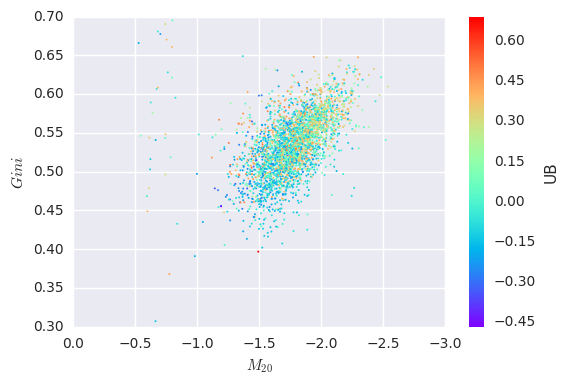

In [131]:
plot_g_m20('r', 'face')

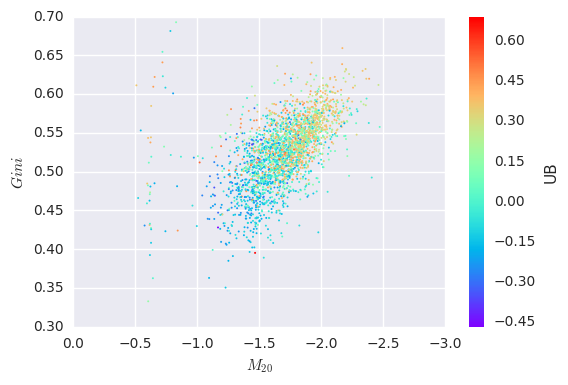

In [132]:
plot_g_m20('g', 'face')

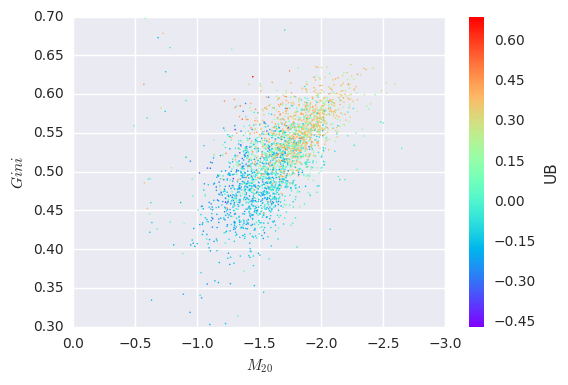

In [182]:
plot_g_m20('g', 'rand')

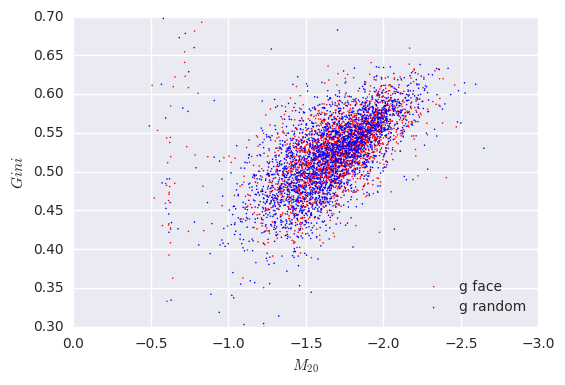

In [183]:
    fig, ax = plt.subplots()
    
    df[(df.filtro == 'g') & (df.orientación == 'face')] \
        .plot.scatter(x='m20', y='gini', c='r', s=5, edgecolor='none', ax=ax, marker='.', label='g face')
    
    df[(df.filtro == 'g') & (df.orientación == 'rand')] \
        .plot.scatter(x='m20', y='gini', c='b', s=5, edgecolor='none', ax=ax, marker='.', label='g random')
        
    plt.legend(loc=4)
    plt.xlim(plt.xlim(-3,0)[::-1])
    plt.ylim(.3,.7)
    plt.xlabel('$M_{20}$')
    plt.ylabel('$Gini$')
    plt.savefig('g_face_g_rand_gini_vs_m20.png')

In [82]:
df = pd.merge(eagle_sfr, lotz, how='inner', on='id')

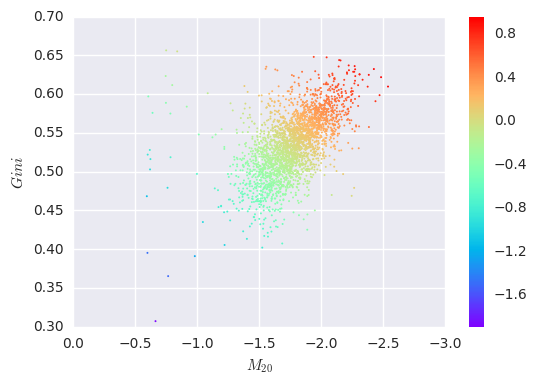

In [83]:
fig, ax = plt.subplots()
df.plot.scatter(x='m20', y='gini', c=df.f, s=2, edgecolor='none', cmap='rainbow', ax=ax)
plt.xlim(plt.xlim(-3,0)[::-1])
plt.ylim(0.3,0.7)
plt.xlabel('$M_{20}$')
plt.ylabel('$Gini$')
plt.savefig('F_gini_vs_m20.png')

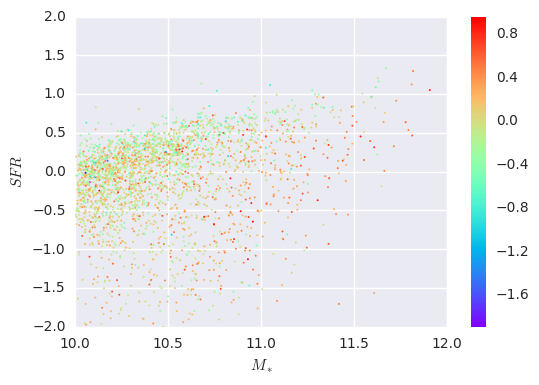

In [84]:
plt.scatter(x=np.log10(df.mass), y=np.log10(df.sfr), c=df.f, s=2, edgecolor='none', cmap='rainbow')
plt.colorbar()
plt.xlabel('$M_*$')
plt.ylabel('$SFR$')
plt.ylim(-2,2)
plt.xlim(10,12)
plt.savefig('SFR_vs_mass.png')

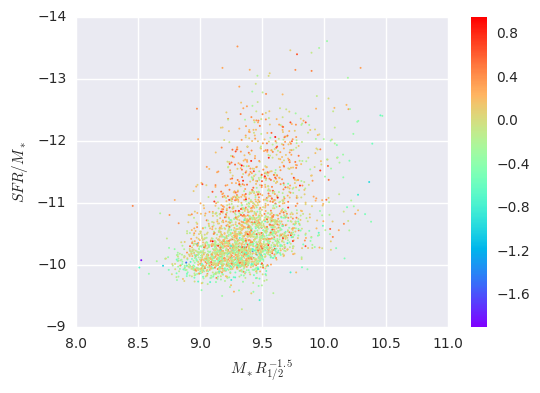

In [85]:
plt.scatter(x=np.log10(df.mass * np.power(df.half_mass_r, -1.5)), y=np.log10(df.sfr/df.mass), c=df.f, s=2, edgecolor='none', cmap='rainbow')
plt.ylim(plt.ylim()[::-1])
plt.colorbar()
plt.xlabel('$M_* R_{1/2}^{-1.5}$')
plt.ylabel('$SFR/M_*$')
plt.savefig('specific_SFR_vs_compactness.png')

**Publicaciones**
Abrham: antecedente de Lotz (no es tan importante).
Snyder: Gini-M20 Illustris.
Torrey: fits Illustris.
Trayford: fits EAGLE.
Lotz: código.

**TODO**

* ¿Qué hace el código de Lotz con los parámetros de `morph.dat` (como PSF)?
* ~~Invertir eje SRF/M~~
* ~~Arreglar G-M20~~
* ~~r face deberían ser 3625 galaxias~~
* Comparación con g-r de Illustris -> cambio por g-i porque Illustris no tiene la banda r
* EAGLE zoo (clasificación visual)
* Machine learning
* momento angular eagle (paper lagos)
* Gini-M20
  * r face
  * g face
  * g rand
  
* Gini-M20 superpuestos Illustris / EAGLE en g_face
* Gini-M20 superpuestos g_face / g_rand

11/7

* Aplicar ML de Illustris a EAGLE
* EAGLE zoo
* Documento Latex
  * Intro
  * Iraf
  * Lotz
  * Gini M20 vs propiedades (EAGLE)
    * Todos los plots que hay
  * ML Illustris
    * Mención de la técnica usada
  * ML de Illustris a EAGLE

## Illustris

http://www.illustris-project.org/data/docs/specifications

In [6]:
morfologías = h5py.File('../illustris/nonparametric_morphologies.hdf5', 'r')
circularidades = h5py.File('../illustris/stellar_circs.hdf5', 'r')

filtros = ['gSDSS', 'iSDSS', 'uSDSS', 'hWFC3']
cámaras = ['cam0', 'cam1', 'cam2', 'cam3']

In [7]:
il = pd.DataFrame()

for filtro in filtros:
    for cámara in cámaras:
        m = pd.DataFrame()
        
        m['id'] = morfologías['Snapshot_135/SubfindID_%s' % cámara]
        
        m['filtro'] = filtro
        m['cámara'] = cámara
        
        m['gini'] = morfologías['Snapshot_135/%s/Gini_%s' % (filtro, cámara)]
        m['m20']  = morfologías['Snapshot_135/%s/M20_%s'  % (filtro, cámara)]
        m['concentration']     = morfologías['Snapshot_135/%s/C_%s'  % (filtro, cámara)]
        m['petrosian_radius']  = morfologías['Snapshot_135/%s/RP_%s' % (filtro, cámara)]
        m['half_light_radius'] = morfologías['Snapshot_135/%s/RE_%s' % (filtro, cámara)]
        
        il = pd.concat([il, m])

In [ ]:
c = pd.DataFrame()

c['id'] = circularidades['Snapshot_135/SubfindID']
c['specific_angular_momentum'] = circularidades['/Snapshot_135/SpecificAngMom']
c['e']  = circularidades['Snapshot_135/CircAbove07Frac']

In [15]:
df = pd.merge(il, c, how='inner', on='id')
#df.set_index('id', inplace=True)

In [25]:
g = df[df.filtro == 'gSDSS']

In [56]:
g

,id,filtro,cámara,gini,m20,concentration,petrosian_radius,half_light_radius,specific_angular_momentum,e
0,0,gSDSS,cam0,0.63,-2.86,5.38,170.380005,51.840000,6481.648926,0.061632
1,0,gSDSS,cam1,0.61,-2.68,4.90,109.769997,36.959999,6481.648926,0.061632
2,0,gSDSS,cam2,0.62,-2.86,5.29,139.919998,45.360001,6481.648926,0.061632
3,0,gSDSS,cam3,0.62,-2.85,5.21,140.729996,45.119999,6481.648926,0.061632
16,1,gSDSS,cam0,0.59,-2.43,4.47,34.029999,11.520000,2780.970459,0.103851
17,1,gSDSS,cam1,0.60,-2.55,4.65,35.029999,11.760000,2780.970459,0.103851
18,1,gSDSS,cam2,0.59,-2.43,4.34,28.320000,10.560000,2780.970459,0.103851
19,1,gSDSS,cam3,0.60,-2.32,4.44,26.860001,9.600000,2780.970459,0.103851
32,2,gSDSS,cam0,0.59,-2.25,3.90,22.990000,7.680000,2914.752441,0.094408
33,2,gSDSS,cam1,0.56,-2.21,3.87,20.830000,7.680000,2914.752441,0.094408


In [48]:
X, y = g[['gini', 'm20', 'concentration', 'petrosian_radius', 'half_light_radius']], g['e']

In [49]:
import sklearn.model_selection

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X.values, y.values, random_state=1)

### AutoML

In [41]:
import sklearn.metrics
import autosklearn
import autosklearn.regression

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=360,
    per_run_time_limit=60,
    initial_configurations_via_metalearning=2,
    ensemble_size=5,
    ensemble_nbest=5,
    seed=1,
    ml_memory_limit=1072
)

In [ ]:
automl.fit(X_train, y_train)

In [ ]:
automl.predict(X_test.values)

In [ ]:
print(automl.show_models())
predictions = automl.predict(X_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))

### TPOT

In [43]:
from tpot import TPOTRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [51]:
tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2, config_dict='TPOT light', n_jobs=3)
tpot.fit(X_train, y_train)

Optimization Progress:  32%|███▎      | 39/120 [02:24<18:42, 13.85s/pipeline] 

Generation 1 - Current best internal CV score: 0.006922273337841034


Optimization Progress:  49%|████▉     | 59/120 [02:33<03:38,  3.58s/pipeline]

Generation 2 - Current best internal CV score: 0.006922273337841034


Optimization Progress:  64%|██████▍   | 77/120 [02:58<03:00,  4.19s/pipeline]

Generation 3 - Current best internal CV score: 0.006922273337841034


Optimization Progress:  79%|███████▉  | 95/120 [07:12<04:07,  9.89s/pipeline]

Generation 4 - Current best internal CV score: 0.006795954797416926


Generation 5 - Current best internal CV score: 0.00679117813706398

Best pipeline: KNeighborsRegressor(MaxAbsScaler(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False)), KNeighborsRegressor__n_neighbors=79, KNeighborsRegressor__p=DEFAULT, KNeighborsRegressor__weights=DEFAULT)


TPOTRegressor(config_dict={'sklearn.linear_model.LassoLarsCV': {'normalize': [True, False]}, 'sklearn.linear_model.ElasticNetCV': {'l1_ratio': array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ]), '... 0.0001, 0.001, 0.01, 0.1], 'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 15.0, 20.0, 25.0]}},
       crossover_rate=0.1, cv=5, disable_update_check=False, generations=5,
       max_eval_time_mins=5, max_time_mins=None, mutation_rate=0.9,
       n_jobs=3, offspring_size=20, population_size=20, random_state=None,
       scoring=None, subsample=1.0, verbosity=2, warm_start=False)

In [52]:
tpot.score(X_test, y_test)

0.0066012481379387217

In [55]:
tpot.export('galaxies.py')

In [ ]:
X.plot.scatter(x='m20', y='gini', c='b', s=5, edgecolor='none', ax=ax, marker='.', label='g random Illustris')

### Otras cosas

In [136]:
df.groupby(['filtro', 'cámara'])

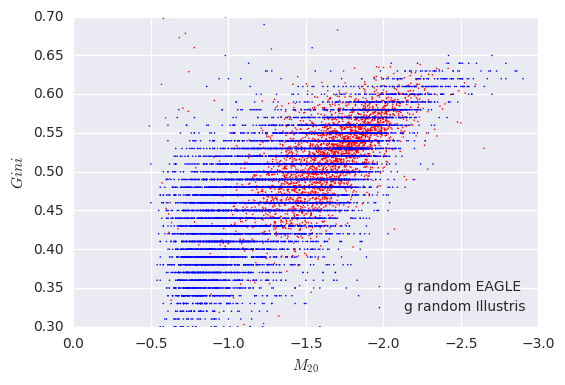

In [197]:
    fig, ax = plt.subplots()
    
    df[(df.filtro == 'g') & (df.orientación == 'rand')] \
        .plot.scatter(x='m20', y='gini', c='r', s=5, edgecolor='none', ax=ax, marker='.', label='g random EAGLE')
    
    il[(il.filtro == 'gSDSS') & (il.cámara == 'cam0')] \
        .plot.scatter(x='m20', y='gini', c='b', s=5, edgecolor='none', ax=ax, marker='.', label='g random Illustris')
        
    plt.legend(loc=4)
    plt.xlim(plt.xlim(-3,0)[::-1])
    plt.ylim(.3,.7)
    plt.xlabel('$M_{20}$')
    plt.ylabel('$Gini$')
    plt.savefig('g_rand_illustris_eagle_gini_vs_m20.png')

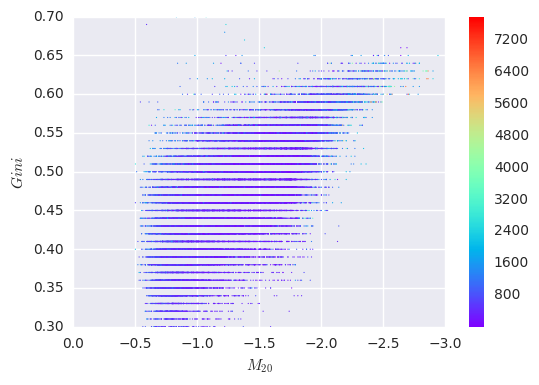

In [71]:
plt.scatter(x=g.m20, y=g.gini, c=g.specific_angular_momentum, s=3, edgecolor='none', marker='.', cmap='rainbow')
#plt.legend(loc=4)
plt.xlim(plt.xlim(-3,0)[::-1])
plt.ylim(.3,.7)
plt.colorbar()
plt.xlabel('$M_{20}$')
plt.ylabel('$Gini$')
#    plt.savefig('g_rand_illustris_eagle_gini_vs_m20.png')

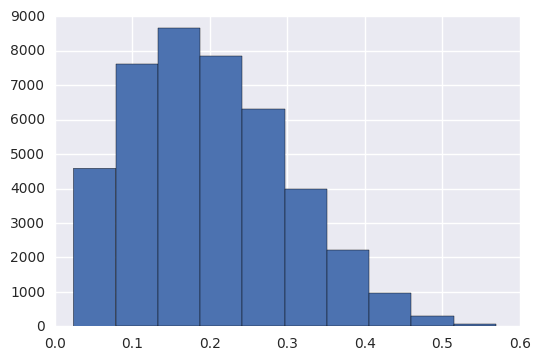

In [72]:
g.e.hist()